C:\Users\edier\AppData\Local\Temp\ipykernel_22044\2040926477.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_stations_df['Mes'] = all_stations_df.index.month
C:\Users\edier\AppData\Local\Temp\ipykernel_22044\2040926477.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_stations_df['Hora'] = all_stations_df.index.hour
C:\Users\edier\AppData\Local\Temp\ipykernel_22044\2040926477.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

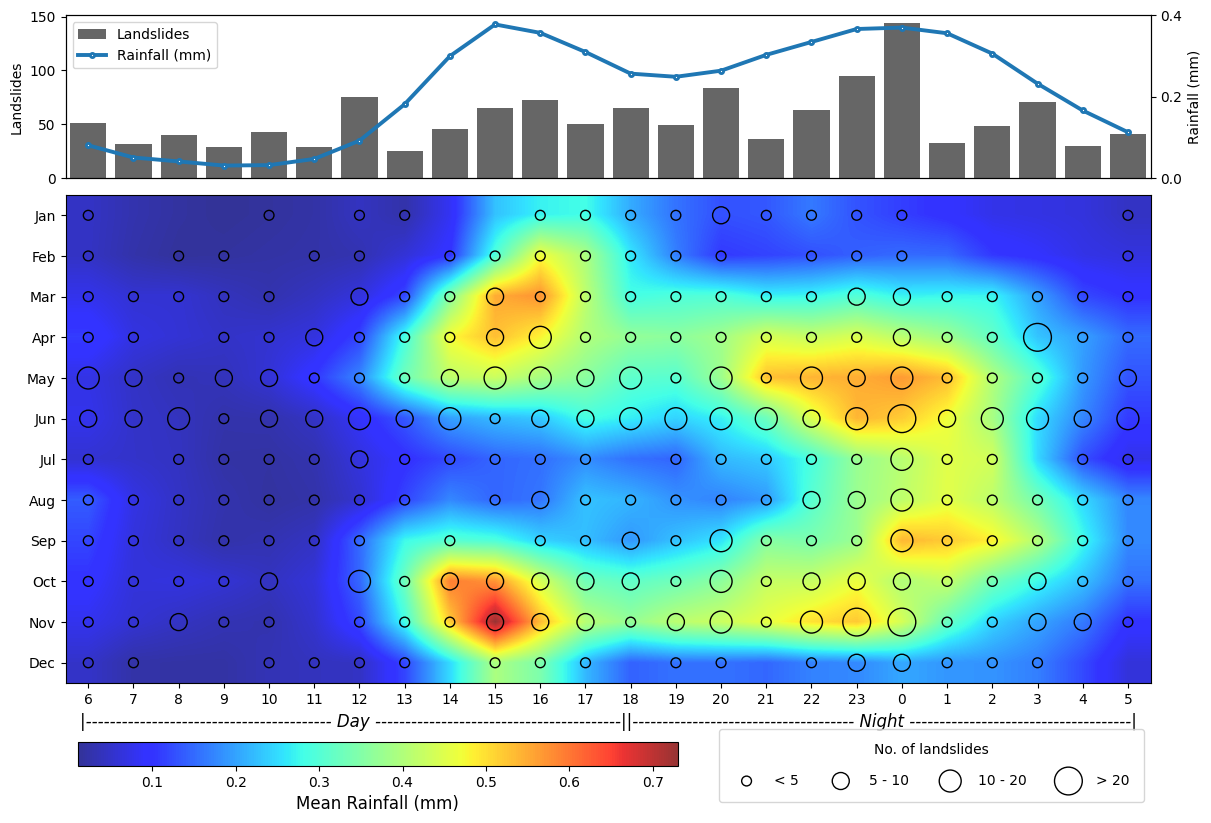

In [21]:
hourly_input = "../../DATA/rainfall/hourly_gauges_SIATA_EPM/"  # Ajusta esta ruta
path_inventory = "../../DATA/landslides/"  # Ajusta esta ruta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import glob

# Definir los tamaños de los círculos según los intervalos
def get_circle_size(value):
    if value == 0:
        return 0  # Sin círculo
    elif 1 <= value <= 5:
        return 50  # Círculo pequeño
    elif 6 <= value <= 10:
        return 150  # Círculo mediano
    elif 11 <= value <= 20:
        return 250  # Círculo grande
    elif 21 <= value:
        return 400  # Círculo muy grande

# Leer y concatenar archivos CSV
def read_and_concat_files(file_paths, exclude_epm=False):
    if exclude_epm:
        file_paths = file_paths[:-16]  # Sin las estaciones de EPM
    
    data_frames = []
    for file in file_paths:
        station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True, usecols=lambda col: 'Unnamed: 0' not in col)
        data_frames.append(station_data)
    
    return pd.concat(data_frames, axis=1)

# Leer y ordenar archivos
hourly_files = sorted(glob.glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))
stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in hourly_files]
stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
hourly_files = [station[1] for station in stations_with_paths_sorted]

# Leer y procesar los datos de todas las estaciones
all_stations_df = read_and_concat_files(hourly_files, exclude_epm=True)
all_stations_df = all_stations_df[(all_stations_df.index >= '2010-01-01') & (all_stations_df.index <= '2023-12-31')]

# Asegurarse de que el índice es de tipo datetime
all_stations_df.index = pd.to_datetime(all_stations_df.index)

# Agregar columnas para el mes y la hora
all_stations_df['Mes'] = all_stations_df.index.month
all_stations_df['Hora'] = all_stations_df.index.hour

# Calcular el total de precipitación promedio por hora
all_stations_df['Total_P'] = all_stations_df.filter(like='P').mean(axis=1)

# Agrupar por mes y hora
monthly_hourly_rainfall = all_stations_df.groupby(['Mes', 'Hora'])['Total_P'].mean().unstack(level='Hora')

# Reordenar las horas
horas_reordenadas = list(range(6, 24)) + list(range(6))  # Reordenar para que empiece de 6 a 5
monthly_hourly_rainfall_reordenado = monthly_hourly_rainfall.reindex(columns=horas_reordenadas)

# Procesar datos de deslizamientos
landslides_df = pd.read_csv(f'{path_inventory}inventory_DAGRD.csv')
landslides_df['fecha_hora_evento'] = pd.to_datetime(landslides_df['fecha_hora_evento'], errors='coerce')
landslides_df['Hora'] = landslides_df['fecha_hora_evento'].dt.hour
landslides_by_hour = landslides_df.groupby('Hora').size()

# Reindexar los datos de deslizamientos según las horas reordenadas
landslides_by_hour_reordenado = landslides_by_hour.reindex(horas_reordenadas, fill_value=0)

# Crear una matriz con los tamaños escalados para el mapa de calor
landslides_by_hour_month = landslides_df.groupby([landslides_df['fecha_hora_evento'].dt.month, 'Hora']).size().unstack(fill_value=0)
landslides_by_hour_month = landslides_by_hour_month.reindex(columns=horas_reordenadas)
scaled_sizes = np.array([[get_circle_size(val) for val in row] for row in landslides_by_hour_month.values])

# Graficar los datos
figsize = (12, 8)
fig, (ax_top, ax) = plt.subplots(nrows=2, figsize=figsize, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)

bar_width = 0.8
x_pos = range(len(horas_reordenadas))

# Parte superior: gráfica de barras y línea
# Datos ficticios para data_PM_reordenado, reemplazar con los datos reales
data_PM_reordenado = all_stations_df.groupby('Hora')['Total_P'].mean().reindex(horas_reordenadas, fill_value=0)

ax2 = ax_top.twinx()
ax2.plot(x_pos, data_PM_reordenado.values, color="#1f77b4", marker='o', linestyle='-', linewidth=2.8, markerfacecolor='white', markeredgewidth=2, markersize=3, label="Rainfall (mm)", zorder=2)

ax2.set_ylabel("Rainfall (mm)", color="black", fontsize=10)
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_yticks([0.0, 0.2, 0.4])  # Añadir etiquetas de tick 0.0 y 0.4 en el eje y derecho

ax_top.bar(x_pos, landslides_by_hour_reordenado.values, color="black", alpha=0.6, width=bar_width, label="Landslides", zorder=2)
ax_top.set_ylabel("Landslides", color="black", fontsize=10)
ax_top.tick_params(axis='y', labelcolor="black")

# Eliminar las etiquetas del eje X en la gráfica superior
ax_top.set_xticks([])
ax_top.set_xticklabels([])

# Agregar leyendas a los gráficos de la parte superior
lines, labels = ax_top.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax_top.legend(lines + lines2, labels + labels2, loc='upper left')

# Parte inferior: Mapa de calor
im = ax.imshow(monthly_hourly_rainfall_reordenado.values, cmap='jet', interpolation='bilinear', aspect='auto', alpha=0.8)

# Configurar el eje X e Y en el mapa de calor
ax.set_xlabel('|----------------------------------------- Day -----------------------------------------||------------------------------------- Night -------------------------------------|', style ='italic', fontsize = 12, )

# Configurar las etiquetas del eje Y
ax.set_yticks(np.arange(12))
ax.set_yticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=0, fontsize=10)
ax.set_xticks(np.arange(len(horas_reordenadas)))
ax.set_xticklabels(horas_reordenadas, fontsize=10)

# Ajuste para alinear los círculos
total_months, total_hours = landslides_by_hour_month.shape
for i in range(total_months):
    for j in range(total_hours):
        val = landslides_by_hour_month.iloc[i, j]
        if val > 0:
            ax.scatter(j, i, s=scaled_sizes[i, j], facecolor='none', edgecolor='black', linewidth=1)

# Asegurarse de que los límites del eje X sean consistentes en ambos gráficos
ax_top.set_xlim(-0.5, len(horas_reordenadas) - 0.5)

# Barra de color
cax = fig.add_axes([0.06, 0.05, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Mean Rainfall (mm)', fontsize=12)

# Crear leyenda personalizada para los tamaños de los círculos
legend_labels = ['< 5', '5 - 10', '10 - 20', '> 20']
legend_sizes = [50, 150, 250, 400]

legend_circles = [plt.scatter([], [], s=size, facecolor='none', edgecolor='black', linewidth=1) for size in legend_sizes]
ax.legend(legend_circles, legend_labels, loc='upper right', bbox_to_anchor=(1.0, -0.08), 
          title="No. of landslides", borderpad=1, handletextpad=1, labelspacing=1.2, ncol=4, fontsize=10)

#plt.savefig('../../FIGURES/temporal_analysis/hourly_monthly_scale_2.png', format='png', dpi=500, bbox_inches="tight")

C:\Users\edier\AppData\Local\Temp\ipykernel_32368\1879764748.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_stations_df['ENSO'] = all_stations_df.apply(
C:\Users\edier\AppData\Local\Temp\ipykernel_32368\1879764748.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_stations_df['Total_P'] = all_stations_df.filter(like='P').mean(axis=1)


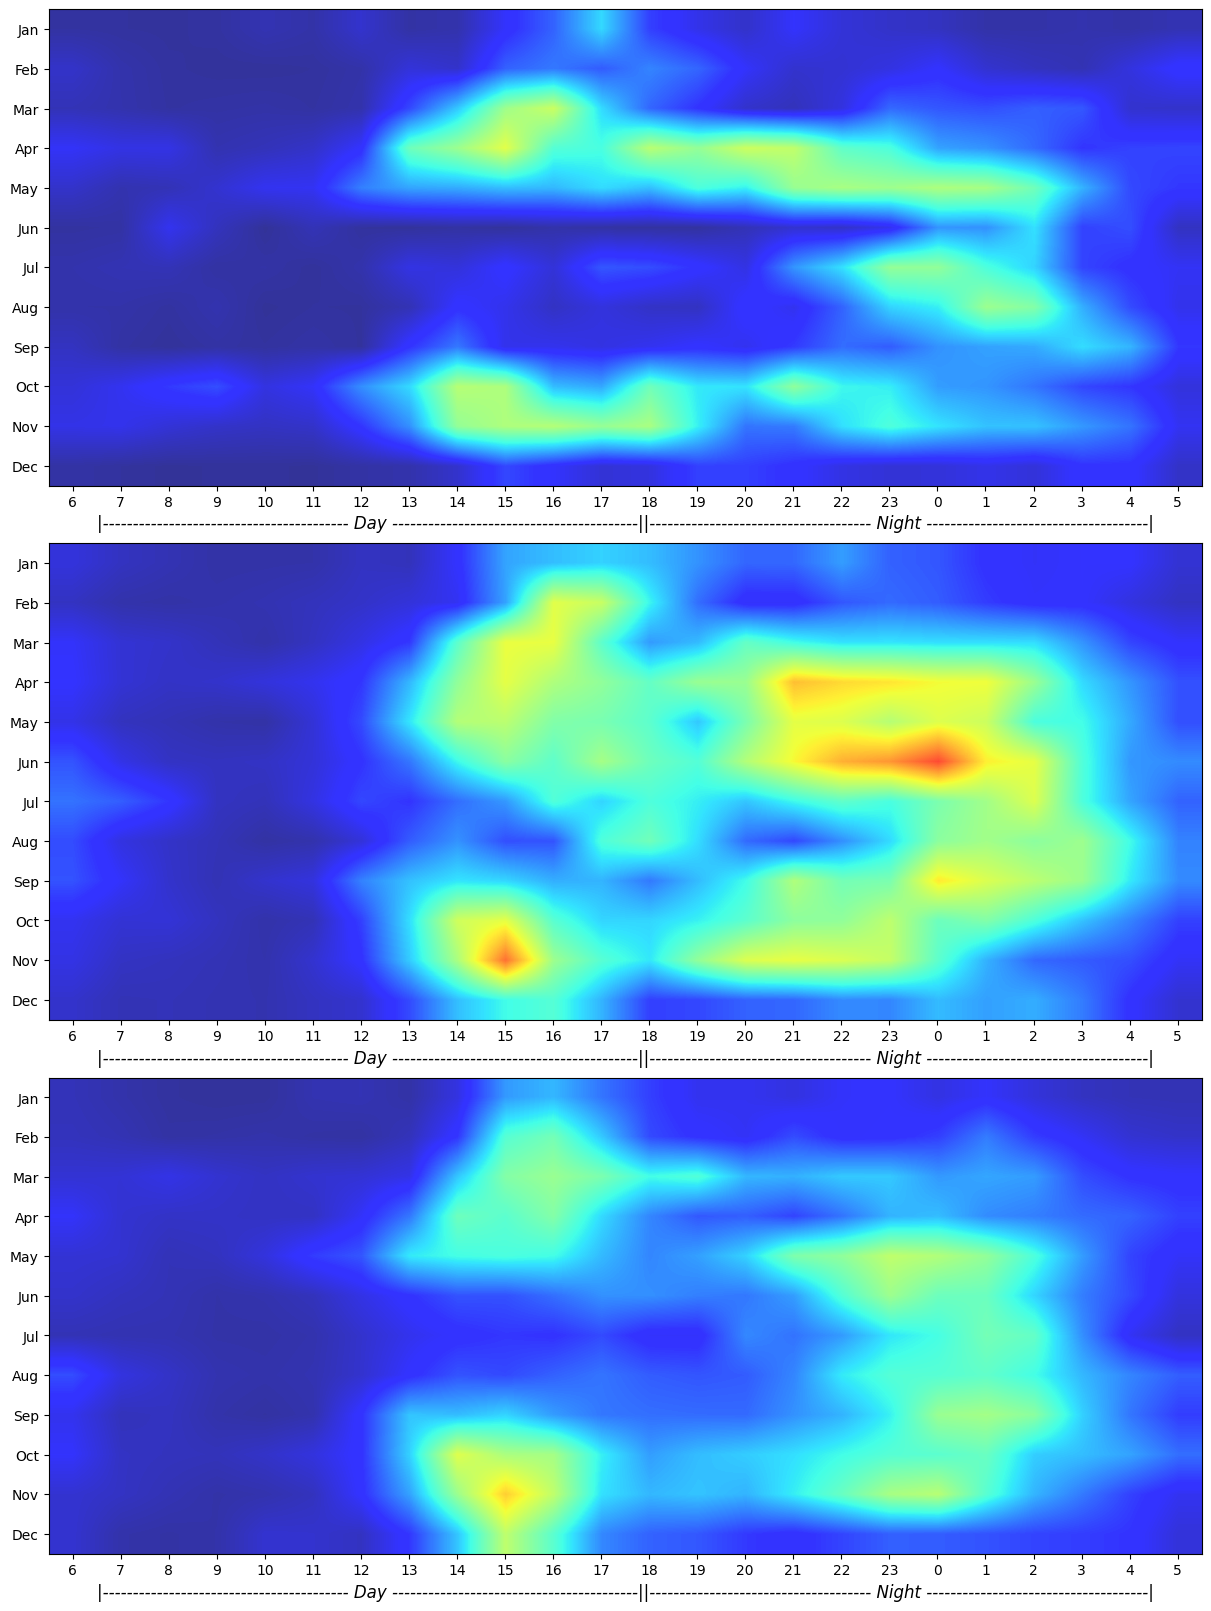

In [9]:
hourly_input = "../../DATA/rainfall/hourly_gauges_SIATA_EPM/"  # Ajusta esta ruta
path_inventory = "../../DATA/landslides/"  # Ajusta esta ruta
ONI_input = "../../DATA/rainfall/ENSO/"  # Ajusta esta ruta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import glob

# Definir los tamaños de los círculos según los intervalos
def get_circle_size(value):
    if value == 0:
        return 0  # Sin círculo
    elif 1 <= value <= 5:
        return 50  # Círculo pequeño
    elif 6 <= value <= 10:
        return 150  # Círculo mediano
    elif 11 <= value <= 20:
        return 250  # Círculo grande
    elif 21 <= value:
        return 400  # Círculo muy grande

# Leer y concatenar archivos CSV
def read_and_concat_files(file_paths, exclude_epm=False):
    if exclude_epm:
        file_paths = file_paths[:-16]  # Sin las estaciones de EPM
    
    data_frames = []
    for file in file_paths:
        station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True, usecols=lambda col: 'Unnamed: 0' not in col)
        data_frames.append(station_data)
    
    return pd.concat(data_frames, axis=1)

# Leer ONI y clasificar fases ENSO
oni_df = pd.read_excel(ONI_input + "/ONI.xlsx")

# Expandir datos estacionales a datos mensuales
season_to_months = {
    'DJF': [12, 1, 2],
    'JFM': [1, 2, 3],
    'FMA': [2, 3, 4],
    'MAM': [3, 4, 5],
    'AMJ': [4, 5, 6],
    'MJJ': [5, 6, 7],
    'JJA': [6, 7, 8],
    'JAS': [7, 8, 9],
    'ASO': [8, 9, 10],
    'SON': [9, 10, 11],
    'OND': [10, 11, 12],
    'NDJ': [11, 12, 1]
}

monthly_oni = []

for _, row in oni_df.iterrows():
    year = row['Year']
    for season, months in season_to_months.items():
        for month in months:
            if season in row:
                month_data = {
                    'Year': year if month != 12 else year - 1,  # December should belong to the previous year
                    'Month': month,
                    'ONI': row[season]
                }
                monthly_oni.append(month_data)

monthly_oni_df = pd.DataFrame(monthly_oni)
monthly_oni_df['Fecha'] = pd.to_datetime(monthly_oni_df[['Year', 'Month']].assign(Day=1))
monthly_oni_df['ENSO'] = pd.cut(monthly_oni_df['ONI'], bins=[-np.inf, -0.5, 0.5, np.inf], labels=['La Niña', 'Neutral', 'El Niño'])

# Definir las horas reordenadas
horas_reordenadas = list(range(6, 24)) + list(range(6))  # Reordenar para que empiece de 6 a 5

# Leer y ordenar archivos
hourly_files = sorted(glob.glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))
stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in hourly_files]
stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
hourly_files = [station[1] for station in stations_with_paths_sorted]

# Leer y procesar los datos de todas las estaciones
all_stations_df = read_and_concat_files(hourly_files, exclude_epm=True)
all_stations_df = all_stations_df[(all_stations_df.index >= '2010-01-01') & (all_stations_df.index <= '2023-12-31')]

# Asegurarse de que el índice es de tipo datetime
all_stations_df.index = pd.to_datetime(all_stations_df.index)

# Crear columnas adicionales (Mes, Hora, Año)
additional_cols = pd.DataFrame({
    'Mes': all_stations_df.index.month,
    'Hora': all_stations_df.index.hour,
    'Year': all_stations_df.index.year
}, index=all_stations_df.index)

# Concatenar columnas adicionales con el DataFrame principal
all_stations_df = pd.concat([all_stations_df, additional_cols], axis=1)

# Asociar los deslizamientos y las lluvias con las fases ENSO
all_stations_df['ENSO'] = all_stations_df.apply(
    lambda x: monthly_oni_df.loc[
        (monthly_oni_df['Year'] == x['Year']) & (monthly_oni_df['Month'] == x['Mes']), 'ENSO'
    ].values[0],
    axis=1
)

# Calcular el total de precipitación promedio por hora
all_stations_df['Total_P'] = all_stations_df.filter(like='P').mean(axis=1)

# Filtrar por fases ENSO y agrupar por mes y hora
enso_phases = ['El Niño', 'La Niña', 'Neutral']
enso_data = {}

for phase in enso_phases:
    enso_data[phase] = all_stations_df[all_stations_df['ENSO'] == phase].groupby(['Mes', 'Hora'])['Total_P'].mean().unstack(level='Hora').reindex(columns=horas_reordenadas)

# Graficar los datos por fases ENSO
fig, axes = plt.subplots(nrows=3, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 1, 1]}, constrained_layout=True)

for i, phase in enumerate(enso_phases):
    ax = axes[i]
    im = ax.imshow(enso_data[phase].values, cmap='jet', interpolation='bilinear', aspect='auto', alpha=0.8, vmin=0, vmax=1)
    #ax.set_title(f"Rainfall during {phase} phases", fontsize=14)
    ax.set_xlabel('|----------------------------------------- Day -----------------------------------------||------------------------------------- Night -------------------------------------|', style ='italic', fontsize = 12)
    
    # Configurar las etiquetas del eje Y
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels([calendar.month_abbr[j] for j in range(1, 13)], rotation=0, fontsize=10)
    ax.set_xticks(np.arange(len(horas_reordenadas)))
    ax.set_xticklabels(horas_reordenadas, fontsize=10)
    
"""   
    # Barra de color para cada fase
    cax = fig.add_axes([0.06, 0.03 * (i + 1), 0.5, 0.02])
    fig.colorbar(im, cax=cax, orientation='horizontal').set_label('Mean Rainfall (mm)', fontsize=10)
"""
plt.show()





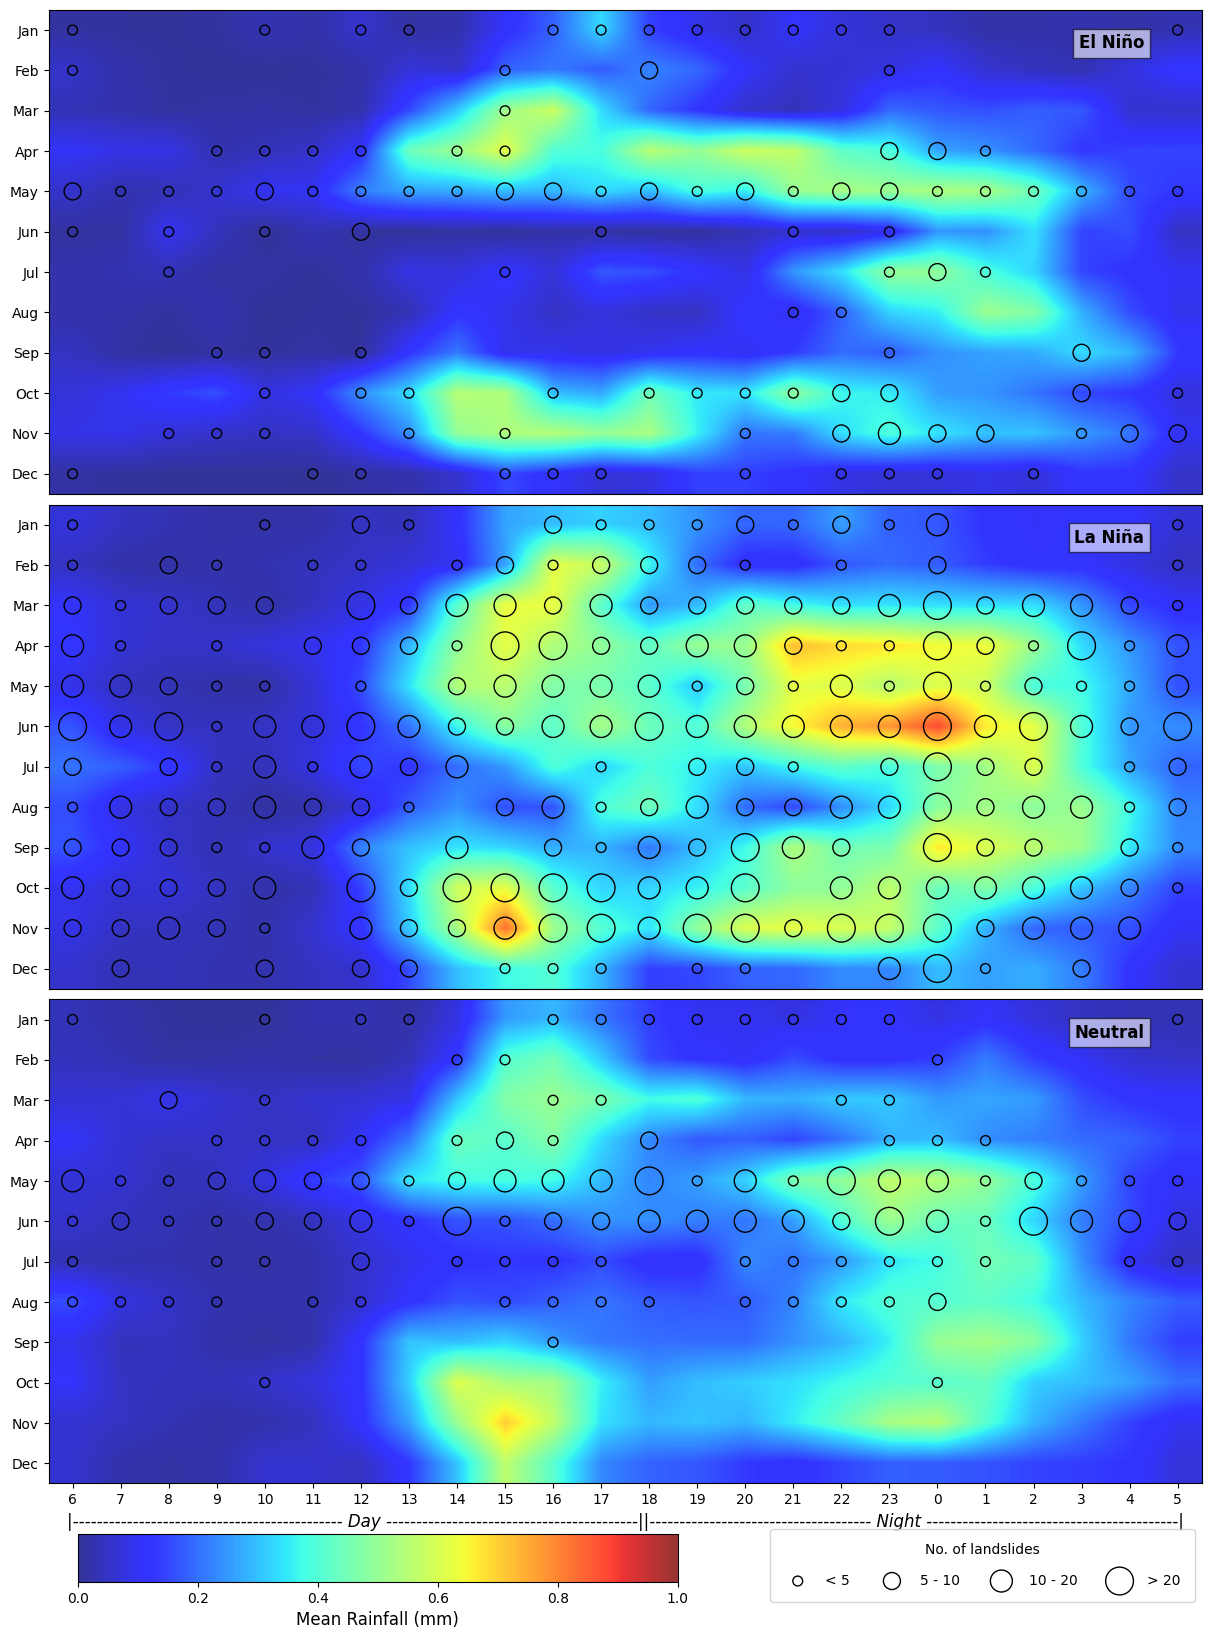

In [32]:
hourly_input = "../../DATA/rainfall/hourly_gauges_SIATA_EPM/"  # Ajusta esta ruta
path_inventory = "../../DATA/landslides/"  # Ajusta esta ruta
ONI_input = "../../DATA/rainfall/ENSO/"  # Ajusta esta ruta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import glob

# Definir los tamaños de los círculos según los intervalos
def get_circle_size(value):
    if value == 0:
        return 0  # Sin círculo
    elif 1 <= value <= 5:
        return 50  # Círculo pequeño
    elif 6 <= value <= 10:
        return 150  # Círculo mediano
    elif 11 <= value <= 20:
        return 250  # Círculo grande
    elif 21 <= value:
        return 400  # Círculo muy grande

# Leer y concatenar archivos CSV
def read_and_concat_files(file_paths, exclude_epm=False):
    if exclude_epm:
        file_paths = file_paths[:-16]  # Sin las estaciones de EPM
    
    data_frames = []
    for file in file_paths:
        station_data = pd.read_csv(file, index_col='Fecha', parse_dates=True, usecols=lambda col: 'Unnamed: 0' not in col)
        data_frames.append(station_data)
    
    return pd.concat(data_frames, axis=1)

# Leer ONI y clasificar fases ENSO
oni_df = pd.read_excel(ONI_input + "/ONI.xlsx")

# Expandir datos estacionales a datos mensuales
season_to_months = {
    'DJF': [12, 1, 2],
    'JFM': [1, 2, 3],
    'FMA': [2, 3, 4],
    'MAM': [3, 4, 5],
    'AMJ': [4, 5, 6],
    'MJJ': [5, 6, 7],
    'JJA': [6, 7, 8],
    'JAS': [7, 8, 9],
    'ASO': [8, 9, 10],
    'SON': [9, 10, 11],
    'OND': [10, 11, 12],
    'NDJ': [11, 12, 1]
}

monthly_oni = []

for _, row in oni_df.iterrows():
    year = row['Year']
    for season, months in season_to_months.items():
        for month in months:
            if season in row:
                month_data = {
                    'Year': year if month != 12 else year - 1,  # December should belong to the previous year
                    'Month': month,
                    'ONI': row[season]
                }
                monthly_oni.append(month_data)

monthly_oni_df = pd.DataFrame(monthly_oni)
monthly_oni_df['Fecha'] = pd.to_datetime(monthly_oni_df[['Year', 'Month']].assign(Day=1))
monthly_oni_df['ENSO'] = pd.cut(monthly_oni_df['ONI'], bins=[-np.inf, -0.5, 0.5, np.inf], labels=['La Niña', 'Neutral', 'El Niño'])

# Definir las horas reordenadas
horas_reordenadas = list(range(6, 24)) + list(range(6))  # Reordenar para que empiece de 6 a 5

# Leer y ordenar archivos
hourly_files = sorted(glob.glob(hourly_input + 'H_Datos_Procesados_Est_*.csv'))
stations_with_paths = [(int(file.split('_')[-1].split('.')[0]), file) for file in hourly_files]
stations_with_paths_sorted = sorted(stations_with_paths, key=lambda x: x[0])
hourly_files = [station[1] for station in stations_with_paths_sorted]

# Leer y procesar los datos de todas las estaciones
all_stations_df = read_and_concat_files(hourly_files, exclude_epm=True)
all_stations_df = all_stations_df[(all_stations_df.index >= '2010-01-01') & (all_stations_df.index <= '2023-12-31')]

# Asegurarse de que el índice es de tipo datetime
all_stations_df.index = pd.to_datetime(all_stations_df.index)

# Crear columnas adicionales (Mes, Hora, Año, ENSO, Total_P)
additional_cols = pd.DataFrame({
    'Mes': all_stations_df.index.month,
    'Hora': all_stations_df.index.hour,
    'Year': all_stations_df.index.year,
    'ENSO': all_stations_df.index.map(lambda x: monthly_oni_df.loc[(monthly_oni_df['Year'] == x.year) & (monthly_oni_df['Month'] == x.month), 'ENSO'].values[0]),
    'Total_P': all_stations_df.filter(like='P').mean(axis=1)
}, index=all_stations_df.index)

# Concatenar columnas adicionales con el DataFrame principal
all_stations_df = pd.concat([all_stations_df, additional_cols], axis=1)

# Filtrar por fases ENSO y agrupar por mes y hora
enso_phases = ['El Niño', 'La Niña', 'Neutral']
enso_data = {}

for phase in enso_phases:
    enso_data[phase] = all_stations_df[all_stations_df['ENSO'] == phase].groupby(['Mes', 'Hora'])['Total_P'].mean().unstack(level='Hora').reindex(columns=horas_reordenadas)

# Procesar datos de deslizamientos
landslides_df = pd.read_csv('../../DATA/landslides/inventory_DAGRD.csv')
landslides_df['fecha_hora_evento'] = pd.to_datetime(landslides_df['fecha_hora_evento'], errors='coerce')
landslides_df['Mes'] = landslides_df['fecha_hora_evento'].dt.month
landslides_df['Year'] = landslides_df['fecha_hora_evento'].dt.year
landslides_df['Hora'] = landslides_df['fecha_hora_evento'].dt.hour

# Asignar la fase ENSO a cada evento de deslizamiento
landslides_df = pd.merge(landslides_df, monthly_oni_df[['Year', 'Month', 'ENSO']], left_on=['Year', 'Mes'], right_on=['Year', 'Month'], how='left')

# Agrupar deslizamientos por mes, hora y ENSO
landslides_by_phase = {}

for phase in enso_phases:
    landslides_by_phase[phase] = (
        landslides_df[landslides_df['ENSO'] == phase].groupby(['Mes', 'Hora']).size().unstack(fill_value=0).reindex(columns=horas_reordenadas, fill_value=0)
    )

# Graficar los datos por fases ENSO
fig, axes = plt.subplots(nrows=3, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 1, 1]}, constrained_layout=True)

for i, phase in enumerate(enso_phases):
    ax = axes[i]
    ax.text(0.95, 0.95, phase, transform=ax.transAxes, ha='right', va='top', fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.6))
    im = ax.imshow(enso_data[phase].values, cmap='jet', interpolation='bilinear', aspect='auto', alpha=0.8, vmin=0, vmax=1)
    if i == 2:
        ax.set_xlabel('|--------------------------------------------- Day ------------------------------------------||------------------------------------- Night ------------------------------------------|', style='italic', fontsize=12)

    # Configurar las etiquetas del eje Y
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels([calendar.month_abbr[j] for j in range(1, 13)], rotation=0, fontsize=10)
    if i == 2:
        ax.set_xticks(np.arange(len(horas_reordenadas)))
        ax.set_xticklabels(horas_reordenadas, fontsize=10)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    # Agregar círculos que representan el número de deslizamientos
    total_months, total_hours = landslides_by_phase[phase].shape
    for m in range(total_months):
        for h in range(total_hours):
            val = landslides_by_phase[phase].iloc[m, h]
            circle_size = get_circle_size(val)
            if circle_size > 0:  # Solo agregar el círculo si hay deslizamientos
                ax.scatter(h, m, s=circle_size, facecolor='none', edgecolor='black', linewidth=1)

# Barra de color única para todas las fases
cax = fig.add_axes([0.06, 0.015, 0.5, 0.03])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Mean Rainfall (mm)', fontsize=12)

# Crear leyenda personalizada para los tamaños de los círculos
legend_labels = ['< 5', '5 - 10', '10 - 20', '> 20']
legend_sizes = [50, 150, 250, 400]

legend_circles = [plt.scatter([], [], s=size, facecolor='none', edgecolor='black', linewidth=1) for size in legend_sizes]
axes[2].legend(legend_circles, legend_labels, loc='upper right', bbox_to_anchor=(1.0, -0.09), 
                title="No. of landslides", borderpad=1, handletextpad=1, labelspacing=1.2, ncol=4, fontsize=10)

plt.savefig('../../FIGURES/temporal_analysis/hourly_monthly_ENSO.png', format='png', dpi=500, bbox_inches="tight")

# Mostrar la figura
plt.show()
